# Coffee Usage

Python notebook for analysing the coffee usage in the NBI HEP group, and determining the length of the Christmas vacation from a fit to it.

For a period in 2009-2010, the usage of the old coffey machine in the NBI HEP group was (somewhat irregularly) monitored. Below is the count of total number of cups of coffey ever brewed at given dates. We will mainly focus on the data from around Christmas...


- 28479   4/11-2009     NOTE: This day, we in the following define as day 0! 
- 28674  13/11-2009 
- 28777  18/11-2009 
- 28964  25/11-2009 
- 29041  27/11-2009 
- 29374  10/12-2009 
- ~29650   8/ 1-2010
- 30001  29/ 1-2010 (?)
- 30221   8/ 2-2010
- 30498  21/ 2-2010
- 32412  17/ 5-2010
- 33676  11/ 8-2010
- 34008   9/ 9-2010`


### Author: 
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 04-12-2023

***

In [8]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit import cost
from scipy import stats

and define the parameters of the program:

In [9]:
save_plots = False

## Fitting functions:

First we define a simple linear function:

In [10]:
def func_coffee_simple(x, p0, p1): 
    return p0 + p1*x

Now YOU should add an extra parameter, which is the length of the vacation:

In [18]:
def func_coffee_advanced(x, p0, p1, p2):
    res = []
    
    # Define when the vacation is (i.e. which points are before and which are after).
    # This could in itself be a fitting parameter, but for now we keep things simple.
    start_vacation = 40.0       # I.e. 40 days after the first date, which 4th of November
    
    # Before the vacation, fit with regular linear relation:
    for X in x:
        if (X < start_vacation):
            res.append(p0 + p1*X)
        
        # During the vacation, fit with a constant value for the duration of the vacation (p2):
        elif (start_vacation < X < start_vacation+p2):
            res.append(p0 + p1*start_vacation)
        
        # After the vacation, fit with a line, subtracting the vacation length from the time:
        else:
            res.append(p0 + p1*(X - p2))
    return np.array(res)

    
    # Here goes your function in terms of p0, p1, and p2 (vacation length)...
    #return p0 + p1*x + p2*np.sqrt(np.abs(x)+10.0)       # Just a silly function!
    
# Numpy-way of "vectorizing" the function above:
func_coffee_advanced_vec = np.vectorize(func_coffee_advanced)

The reason why we are using the last line is to allow `func_coffee_advanced` to take Numpy arrays as inputs, so we do not have to loop over entire lists.

## Coffee Usage

Data set (So small that we will not use a seperate file for it!). We define 4th of November 2009 to be day 0, and count from there.

In [12]:
days = np.array([     0,     9,    14,    21,    23,    36,    65,    76,    86,    99,   194,   280,   309 ])
cups = np.array([ 28479, 28674, 28777, 28964, 29041, 29374, 29650, 30001, 30221, 30498, 32412, 33676, 34008 ])
edays = np.zeros_like(days)
ecups = np.ones_like(cups)*30.0   # I estimate the uncertainty to be 30 cups, but perhaps you disagree?
                                  # Certainly, it is NOT the square root, as it is not at all a Poisson number!

# Print the number of days:
for day, cup in zip(days, cups):
    print(f"days: {day:3.0f}    cups: {cup:5.0f}")

days:   0    cups: 28479
days:   9    cups: 28674
days:  14    cups: 28777
days:  21    cups: 28964
days:  23    cups: 29041
days:  36    cups: 29374
days:  65    cups: 29650
days:  76    cups: 30001
days:  86    cups: 30221
days:  99    cups: 30498
days: 194    cups: 32412
days: 280    cups: 33676
days: 309    cups: 34008


## Fit and plot graph on screen:

In [14]:
# Define the relevant range:
xmin, xmax = 60, 105
mask_range = (xmin < days) & (days < xmax)

# Fit the data points in the range (xmin, xmax)
mfit_coffee = cost.LeastSquares(days[mask_range], cups[mask_range], ecups[mask_range], func_coffee_simple)
mfit_coffee = Minuit(mfit_coffee, p0=28000.0, p1=20.0)
mfit_coffee.migrad()

p0, p1 = mfit_coffee.values[:]

print("Simple fit")
for name in mfit_coffee.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, mfit_coffee.values[name], mfit_coffee.errors[name]))

Simple fit
Fit value: p0 = 28086.87440 +/- 98.63542
Fit value: p1 = 24.60890 +/- 1.19617


Plot the data along with the fit on top of the data:

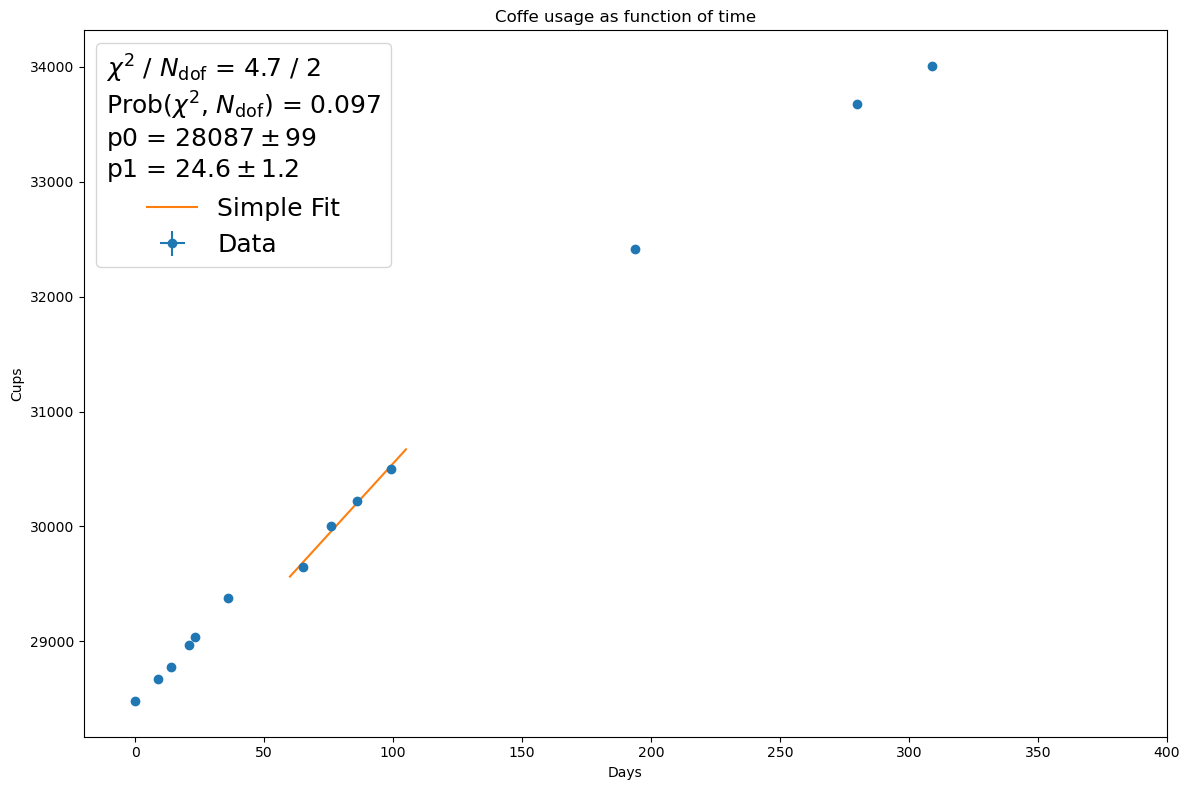

In [15]:
# Plot the data:
fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(days, cups, xerr=edays, yerr=ecups, fmt='o', label='Data')
ax.set(xlim=(-20, 400), xlabel='Days', ylabel='Cups', title='Coffe usage as function of time')

# Plot the fit on top:
x_fit = np.linspace(xmin, xmax, 1000)
y_fit = func_coffee_simple(x_fit, *mfit_coffee.values[:])
ax.plot(x_fit, y_fit, '-', label='Simple Fit')

# Get the ChiSquare probability:
chi2_lin = mfit_coffee.fval
Ndof_lin = len(days[mask_range]) - len(mfit_coffee.values[:])
Prob_lin = stats.chi2.sf(chi2_lin, Ndof_lin)

fit_info = [f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {chi2_lin:.1f} / {Ndof_lin}", f"Prob($\\chi^2$, $N_\\mathrm{{dof}}$) = {Prob_lin:.3f}",]
for p, v, e in zip(mfit_coffee.parameters, mfit_coffee.values[:], mfit_coffee.errors[:]) :
    Ndecimals = max(0,-np.int32(np.log10(e)-1-np.log10(2)))                                # Number of significant digits
    fit_info.append(f"{p} = ${v:{10}.{Ndecimals}{"f"}} \\pm {e:{10}.{Ndecimals}{"f"}}$")

plt.legend(title="\n".join(fit_info), fontsize=18, title_fontsize = 18, alignment = 'center');
fig.tight_layout()

## Advanced fit:
Try to fit the advanced function in the range (-10, 110):

In [19]:
xmin, xmax = -10, 110
mask_range = (xmin < days) & (days < xmax)

# fit the data points in the range (xmin, xmax)
mfit_coffee2 = cost.LeastSquares(days[mask_range], cups[mask_range], ecups[mask_range], func_coffee_advanced)
minuit_coffee2 = Minuit(mfit_coffee2, p0=28500, p1=25, p2=14.0)
minuit_coffee2.migrad();

p0, p1, p2 = minuit_coffee2.values[:]
print("Advanced fit")
for name in minuit_coffee2.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit_coffee2.values[name], minuit_coffee2.errors[name]))

Advanced fit
Fit value: p0 = 28457.62137 +/- 18.41001
Fit value: p1 = 24.88613 +/- 0.80069
Fit value: p2 = 15.80558 +/- 1.74449


and plot the advanced fit:

Advanced fit
Fit value: p0 = 28457.62137 +/- 18.41001
Fit value: p1 = 24.88613 +/- 0.80069
Fit value: p2 = 15.80558 +/- 1.74449


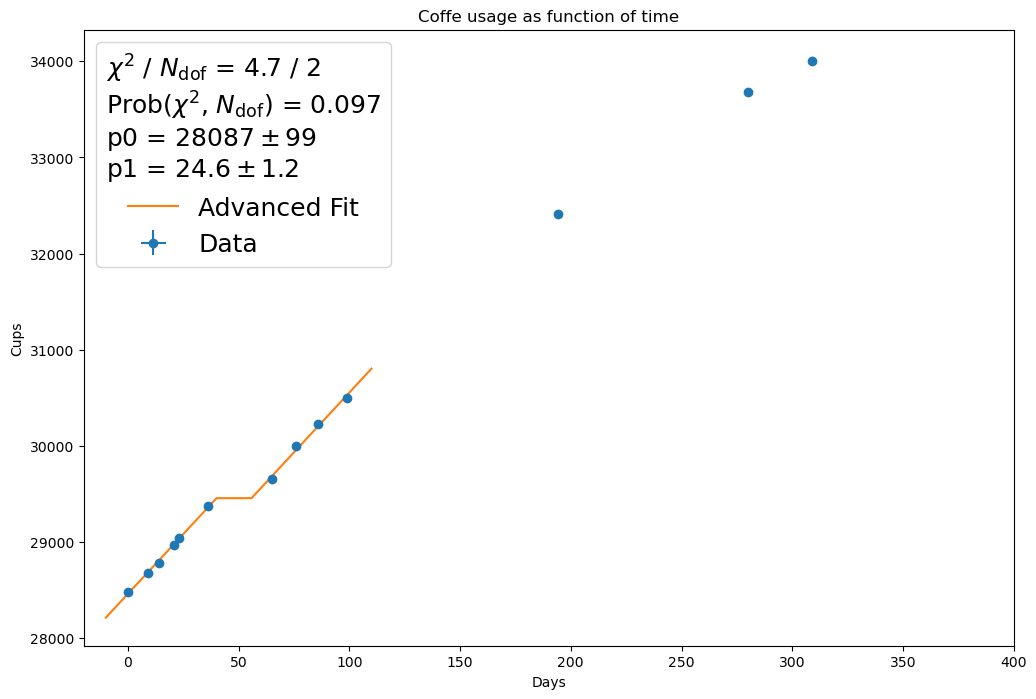

In [23]:
# Plot the data:
fig2, ax2 = plt.subplots(figsize=(12, 8))
ax2.errorbar(days, cups, xerr=edays, yerr=ecups, fmt='o', label='Data')
ax2.set(xlim=(-20, 400), xlabel='Days', ylabel='Cups', title='Coffe usage as function of time')

x_fit = np.linspace(xmin, xmax, 1000)
y_fit = func_coffee_advanced(x_fit, *minuit_coffee2.values[:])
ax2.plot(x_fit, y_fit, '-', label='Advanced Fit')

# Include fit results in the plot:
p0, p1, p2 = minuit_coffee2.values[:]
print("Advanced fit")
for name in minuit_coffee2.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit_coffee2.values[name], minuit_coffee2.errors[name]))

plt.legend(title="\n".join(fit_info), fontsize=18, title_fontsize = 18, alignment = 'center');
fig.tight_layout()


In [24]:
print(f"\n\nThe fitted effective vacation length was: {minuit_coffee2.values['p2']:4.1f} +- {minuit_coffee2.errors['p2']:3.1f} days!\n")



The fitted effective vacation length was: 15.8 +- 1.7 days!



### An example of a very simple estimate for the comissioning and decomisioning date of the coffee machine

In [26]:
# Define a new fitting function, that has x_start and x_end as input (using y = ax + b).
# (We use the start and end days of the coffee machine now, as we're interested in their uncertainties)
def func_coffee3(x, x_start, x_end): 
    return 36716 / (x_end - x_start) * x + 28479

# Now we fit this model throughout the full data range
chi2_object_coffee3 = cost.LeastSquares(days, cups, ecups, func_coffee3)
minuit_coffee3 = Minuit(chi2_object_coffee3, x_start=-600, x_end=400)
minuit_coffee3.migrad();
x_start, x_end = minuit_coffee3.values[:]

print("Simple fit for the whole data range:")
for name in minuit_coffee3.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit_coffee3.values[name], minuit_coffee3.errors[name]))
    
# In years (see true solutions at the bottom):
print(" ")
print(f"Rough estimate of commissioning year: {2009.9 + (x_start / 365): .1f}")
print(f"Rough estimate of decommissioning year: {2009.9 + (x_end / 365): .1f}")

Simple fit for the whole data range:
Fit value: x_start = -1077.84323 +/- 100.64898
Fit value: x_end = 877.84323 +/- 100.64898
 
Rough estimate of commissioning year:  2006.9
Rough estimate of decommissioning year:  2012.3


# Questions:

1. Assuming the error of 30 cups, do the numbers follow the hypothesis of constant use? Quantify this, and find out how large the error has to be, for this hypothesis to be credible.

_Example solution 1_: For the range of 60 to 105 days, the probability that the numbers follow the hypothesis of constant use is 10%. Depending on where you put your significance threshold, this is probably not enough to discard the constant use hypothesis. When we change the estimated error to 40 cups, the probability of the null hypothesis increases to 27%.

2. Consider only the data from the first 100 days(*). Does taking into account Christmas vacations improve the above hypothesis? Can you actually fit the length of vacation? Try to rewrite the function "func_coffee", such that it includes an "if", dividing the function into two linear functions with the same slope, that has an interval with no usage (i.e. the Christmas vacation).

_Example solution 2_: The new advanced function that takes the Christmas holiday into account definitely improves the fit, with a new p-value of 0.42 for an estimated error of 30 cups. The fit also yields an estimate for the vacation length: 15.8 +/- 1.7 days. Since we know the Christmas holiday is 2 school weeks and 3 weekends, this is an imporessively accurate estimate!

3. The total number of cups of coffey ever brewed was 36716, after which the old coffey machine was decommissioned. From the above data, estimate when this happened (including error!). And when would you estimate that the coffey machine was commissioned originally?

_Example solution 3_: See example above. This example uses a very simple fitting function, a straight line. You can probably do better! One way of obtaining easy estimates of the uncertainties is to define your fit function in terms of the parameters you want to obtain. In this case, the fit function takes x_start (the commissioning date of the coffee machine, in number of days before 4/11/2009) and x_end (the decommissioning date of the coffee machine, in days after 4/11/2009) as input parameters. Minuit will optimise these parameters and return immediately their corresponding uncertainties. Another option is to propagate the uncertainties of the parameters p0 and p1, if you use those for the fit.

This approach gives an estimate of November 2006 as the commissioning date, and April 2012 as decommissioning date, both with an uncertainty of around 100 days. This is a very rough estimate indeed, also taken into account the sparse amount of data points, and the true dates are not within the calculated uncertainties.


(*) You can do this, by defining the function range to be 0-100!

***

## Key questions:

- What is the probability that the first 50 days follow a constant usage, assuming the uncertainty of 30 days to be correct?
- How long did you estimate the Christmas vacation to be (including uncertainty)?
- When was the machine commissioned and decommissioned (including uncertainty)?

The original commissioning of the machine was around July 2005 with an uncertainty of around 2 months (source: Esben Klinkby). The new machine commissioning (and thus decommissioning of the old one) was on the 15th of March 2011.